In [1]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64

import analysis_helpers as h
reload(h)

<module 'analysis_helpers' from 'analysis_helpers.pyc'>

In [2]:
# directory & file hierarchy
iterationName = 'pilot2'
exp_path = './'
analysis_dir = os.getcwd()
data_dir = os.path.abspath(os.path.join(os.getcwd(),'..','data',exp_path))
exp_dir = './'
sketch_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','analysis',exp_path,'sketches','pilot2'))

In [4]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['sketchpad_basic']

In [5]:
S = coll.find({ '$and': [{'iterationName':'pilot2'}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':'pilot2'}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

34620 stroke records in the database.
3220 clickedObj records in the database.


In [6]:
# print unique gameid's
unique_gameids = coll.find({ '$and': [{'iterationName':'pilot2'}, {'eventType': 'clickedObj'}]}).sort('time').distinct('gameid')
# print map(str,unique_gameids)

# filter out  records that match researcher ID's
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
researchers = jefan + hawkrobe
workers = [i for i in coll.find({'iterationName':'pilot2'}).distinct('workerId') if i not in researchers]

In [3]:
valid_gameids = []
for i,g in enumerate(unique_gameids):
    W = coll.find({ '$and': [{'gameid': g}]}).distinct('workerId')
    for w in W:
        if w in workers:
            X = coll.find({ '$and': [{'workerId': w}, {'gameid': g}]}).distinct('trialNum') ## # of trials completed
            eventType = coll.find({ '$and': [{'workerId': w}]}).distinct('eventType')
            print i, w[:4], len(X), str(eventType[0])
            if (str(eventType[0])=='clickedObj') & (len(X)==32):
                valid_gameids.append(g)
print '   ===========   '

## filter if the pair cheated by writing words or using other symbols
cheaty = ['8155-e46a25a3-9259-4b76-80e9-5bd79b6bdd97','6224-ab96ed5c-2a98-477c-aae2-7398b9e5b237',\
         '5595-a00b8109-1910-43c4-9f14-00eb4945ac70','1697-7ab5b295-fae8-4f62-8cbd-72aa0e23b10e']
motor = ['2829-820b338d-5720-4964-bd22-8ba38329569d'] # this person made multiples in several of their sketches, and appeared to suffer from strong tremors
unfiltered_gameids = valid_gameids
valid_gameids = [i for i in valid_gameids if i not in cheaty]
valid_gameids = [i for i in valid_gameids if i not in motor]

print str(len(valid_gameids)) + ' valid gameIDs (# complete games).'

df = pd.DataFrame([valid_gameids])
df = df.transpose()
df.columns=['valid_gameids']
df.to_csv('valid_gameids_pilot2.csv')

df = pd.DataFrame([unfiltered_gameids])
df = df.transpose()
df.columns=['unfiltered_gameids']
df.to_csv('unfiltered_gameids_pilot2.csv')

In [4]:
TrialNum = []
GameID = []
Condition = []
Target = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
numStrokes = []
drawDuration = [] # in seconds
viewerRT = []
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = []
Pose = []
Svg = []

these_gameids = unfiltered_gameids

for g in these_gameids:
    print 'Analyzing game: ', g

    X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
    Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

    for t in X:
        targetname = t['intendedName']
        distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
        full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
        y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
        ns = y.count()
        numStrokes.append(ns)
        drawDuration.append((y.__getitem__(ns-1)['time'] - y.__getitem__(0)['time'])/1000) # in seconds  
        y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')        
        z = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}, {'trialNum': t['trialNum']}]}).sort('time')
        viewerRT.append((z.__getitem__(0)['time'] - y.__getitem__(ns-1)['time'])/1000)
        ls = [len(_y['svgData']) for _y in y]
        svgStringLength.append(reduce(lambda x, y: x + y, ls))
        y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
        num_curves = [len([m.start() for m in re.finditer('c', _y['svgData'])]) for _y in y]
        y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')        
        _svg = []
        for _y in y:
            _svg.append(_y['svgData'])
        Svg.append(_svg)
        numCurvesPerSketch.append(reduce(lambda x, y: x + y, num_curves))
        numCurvesPerStroke.append(reduce(lambda x, y: x + y, num_curves)/ns)
        svgStringLengthPerStroke.append(reduce(lambda x, y: x + y, ls)/ns)
        svgStringStd.append(np.std(ls))
        ### aggregate game metadata
        TrialNum.append(t['trialNum'])
        GameID.append(t['gameid'])        
        Target.append(targetname)
        Condition.append(t['condition'])
        Response.append(t['clickedName'])
        Outcome.append(t['correct'])
        Distractor1.append(distractors[0])
        Distractor2.append(distractors[1])
        Distractor3.append(distractors[2])
        Pose.append(t['pose'])
        

In [ ]:
## compose pandas dataframe from lists
iteration = ['pilot2']*len(GameID)

_D = pd.DataFrame([GameID,TrialNum,Condition, Target, drawDuration, Outcome, Response, numStrokes, \
                  svgStringLength, svgStringLengthPerStroke, svgStringStd, Distractor1, Distractor2, \
                   Distractor3, Pose, iteration, Svg, viewerRT]) \

D =_D.transpose()
D.columns = ['gameID','trialNum','condition', 'target', 'drawDuration','outcome', 'response', \
             'numStrokes', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', \
            'Distractor1', 'Distractor2', 'Distractor3', 'pose', 'iteration', 'svg','viewerRT']

In [ ]:
## add png to D dataframe
png = []
for g in these_gameids:
    X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
    Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')
    # print out sketches from all trials from this game
    for t in X: 
        png.append(t['pngString'])
D = D.assign(png=pd.Series(png).values)

iteration = ['pilot2']*len(D['gameID'].values)
D = D.assign(iteration=pd.Series(iteration).values)

## add another cost-related dependent measure: mean pixel intensity (amount of ink spilled) -- to handle
## some weird glitches in the num stroke count
mean_intensity = []
imsize = 100
numpix = imsize**2
thresh = 250

for i,_d in D.iterrows():
    imgData = _d['png']
    filestr = base64.b64decode(imgData)
    fname = os.path.join('sketch.png')
    with open(fname, "wb") as fh:
        fh.write(imgData.decode('base64'))
    im = Image.open(fname).resize((imsize,imsize))
    _im = np.array(im)
    mean_intensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)
    
# add mean_intensity to the main D dataframe 
### btw: mean_intensity and numStrokes is about 0.43 spearman correlated.
D = D.assign(mean_intensity=pd.Series(mean_intensity).values)
print stats.spearmanr(D['mean_intensity'].values,D['numStrokes'].values)

category = [h.objcat[t] for t in D.target.values]
D = D.assign(category=pd.Series(category).values)


In [ ]:
# save D out as group_data.csv 
if len(np.unique(D.gameID.values))==len(valid_gameids):
    D.to_csv(os.path.join(analysis_dir,'sketchpad_basic_pilot2_group_data.csv'))
    print 'Saving out valid games csv'
elif len(np.unique(D.gameID.values))==len(unfiltered_gameids):
    D.to_csv(os.path.join(analysis_dir,'sketchpad_basic_pilot2_group_data_unfiltered.csv'))
    print 'Saving out unfiltered games csv'    

'/Users/data'

### Visualize summary stats

In [9]:
# read group data csv in as D
D = pd.read_csv(os.path.join(data_dir,'csv','sketchpad_basic_pilot2_group_data.csv'))

In [10]:
def get_mean_by_condition_and_game(D,var='numStrokes'):
    '''
    Input: dataframe D and name of variable of interest (which is a column of D)
    Output: two vectors, one for close and one for far condition,
            with mean for each game
    '''
    
    d = D.groupby(['gameID','condition'])[var].mean().reset_index()
    far_d = d[d['condition']=='further'][var].values
    close_d = d[d['condition']=='closer'][var].values
    return far_d, close_d

further_strokes, closer_strokes = get_mean_by_condition_and_game(D, var='numStrokes')
further_drawDuration, closer_drawDuration = get_mean_by_condition_and_game(D, var='drawDuration')
further_meanintensity, closer_meanintensity = get_mean_by_condition_and_game(D, var='mean_intensity')
further_accuracy, closer_accuracy = get_mean_by_condition_and_game(D, var='outcome')
further_viewerRT, closer_viewerRT = get_mean_by_condition_and_game(D, var='viewerRT')

/Users/judithfan/Library/Python/2.7/lib/python/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'communication experiment accuracy timecourse')

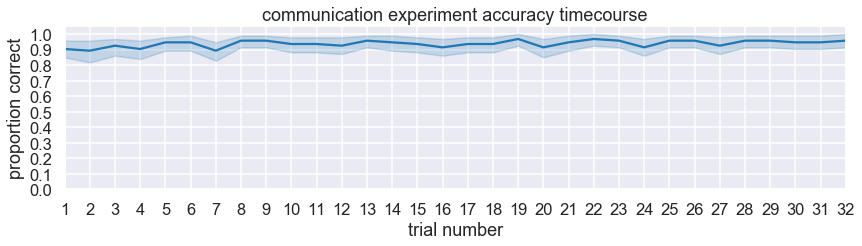

In [5]:
D = pd.read_csv(os.path.join(data_dir,'csv','sketchpad_basic_pilot2_group_data.csv'))
plt.figure(figsize=(14,3))
sns.set_context('talk')
sns.set_style('darkgrid')
sns.lineplot(data=D,
             x = 'trialNum',
             y = 'outcome')
plt.ylim(0,1.05)
plt.ylabel('proportion correct')
plt.xlabel('trial number')
plt.xlim(1,32)
plt.xticks(np.arange(1, 33, 1))
plt.yticks(np.arange(0,1.1,0.1))
plt.title('communication experiment accuracy timecourse')

In [6]:
D.groupby('trialNum')['outcome'].mean()

trialNum
1     0.903226
2     0.892473
3     0.924731
4     0.903226
5     0.946237
6     0.946237
7     0.892473
8     0.956989
9     0.956989
10    0.935484
11    0.935484
12    0.924731
13    0.956989
14    0.946237
15    0.935484
16    0.913978
17    0.935484
18    0.935484
19    0.967742
20    0.913978
21    0.946237
22    0.967742
23    0.956989
24    0.913978
25    0.956989
26    0.956989
27    0.924731
28    0.956989
29    0.956989
30    0.946237
31    0.946237
32    0.956989
Name: outcome, dtype: float64

In [61]:
def trim_outliers(x):
    mu = np.mean(x)
    sd = np.std(x)
    thresh = mu + sd*3
    y = [i for i in x if i<thresh]
    return y

def bootstrap(w,nIter=10000):
    boot = []
    for i in np.arange(nIter):
        boot.append(np.mean(np.random.RandomState(i).choice(w,len(w),replace=True)))
    boot = np.array(boot) 
    p1 = sum(boot<0)/len(boot) * 2
    p2 = sum(boot>0)/len(boot) * 2
    p = np.min([p1,p2])        
    lb = np.percentile(boot,2.5)
    ub = np.percentile(boot,97.5)
    print 'p = {}'.format(p) 
    return boot, p, lb, ub

print D.groupby('condition')['numStrokes'].mean()
print D.groupby('condition')['mean_intensity'].mean()
print D.groupby('condition')['drawDuration'].mean()
print D.groupby('condition')['outcome'].mean()
print D.groupby('condition')['viewerRT'].mean()

condition
closer     13.538306
further     8.077285
Name: numStrokes, dtype: float64
condition
closer     0.053560
further    0.041718
Name: mean_intensity, dtype: float64
condition
closer     30.647843
further    13.873610
Name: drawDuration, dtype: float64
condition
closer     0.879032
further    0.996640
Name: outcome, dtype: float64
condition
closer     8.320626
further    6.319662
Name: viewerRT, dtype: float64


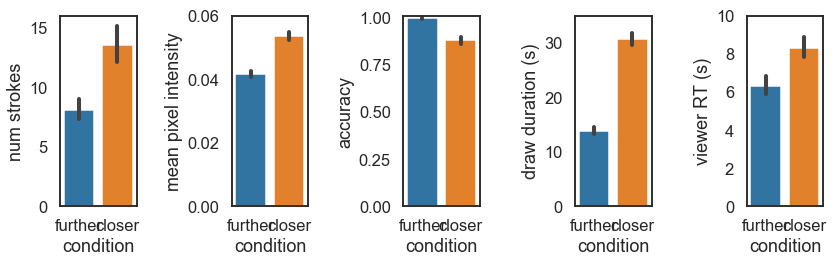

In [38]:
sns.set_context('talk')
plt.figure(figsize=(12,4))
plt.subplot(1,5,1)
ax = sns.barplot(data=D,x='condition',y='numStrokes')
plt.ylabel('num strokes')
plt.ylim(0,16)
plt.subplot(1,5,2)
sns.barplot(data=D,x='condition',y='mean_intensity')
plt.ylabel('mean pixel intensity')
plt.ylim(0,0.06)
plt.subplot(1,5,3)
sns.barplot(data=D,x='condition',y='outcome')
plt.ylabel('accuracy')
plt.ylim([0,1.01])
plt.subplot(1,5,4)
sns.barplot(data=D,x='condition',y='drawDuration')
plt.ylabel('draw duration (s)')
plt.ylim(0,35)
plt.subplot(1,5,5)
ax = sns.barplot(data=D,x='condition',y='viewerRT')
plt.ylabel('viewer RT (s)')
plt.ylim(0,10)
plt.tight_layout()
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/sketchpad_basic_pilot2_taskperformance.pdf')
plt.savefig('../manuscript/figures/raw/sketchpad_basic_taskperformance.pdf')

In [39]:
overall_accuracy = np.mean(D['outcome'].values)
print 'Overall accuracy (collapsing across conditions) = {}'.format(np.round(overall_accuracy,3))

accuracy_by_game = D.groupby('gameID')['outcome'].mean()
boot, p, lb, ub = bootstrap(accuracy_by_game)
print '95% CI for accuracy across games: ({}, {}), p = {}'.format(np.round(lb,3),np.round(ub,3),p)

Overall accuracy (collapsing across conditions) = 0.938
p = 2.0
95% CI for accuracy across games: (0.927, 0.949), p = 0.0


In [64]:
ACG = D.groupby(['gameID','condition'])['outcome'].mean().reset_index()
grouped = ACG.groupby('condition')['outcome']
for name,group in grouped:
    boot, p, lb, ub = bootstrap(group)
    print '95% CI for accuracy for {} condition: [{}, {}], p = {}'.format(name,np.round(lb,3),np.round(ub,3),p)

p = 0.0
95% CI for accuracy for closer condition: [0.858, 0.899], p = 0.0
p = 0.0
95% CI for accuracy for further condition: [0.993, 0.999], p = 0.0


In [40]:
## bootstrapped CI's on main task performance measures
boot, p, lb, ub = bootstrap(closer_strokes)
print '95% CI for closer strokes: ({}, {})'.format(np.round(lb,3),np.round(ub,3))

boot, p, lb, ub = bootstrap(further_strokes)
print '95% CI for further strokes: ({}, {})'.format(np.round(lb,3),np.round(ub,3))


p = 2.0
95% CI for closer strokes: (10.589, 17.981)
p = 2.0
95% CI for further strokes: (6.591, 10.64)


In [41]:
## bootstrapped CI's on main task performance measures
boot, p, lb, ub = bootstrap(further_strokes - closer_strokes)
print '95% CI for closer vs. further strokes: [{}, {}], p = {}'.format(np.round(lb,3),np.round(ub,3),p)

boot, p, lb, ub = bootstrap(further_meanintensity - closer_meanintensity)
print '95% CI for closer vs. further mean intensity: [{}, {}], p = {}'.format(np.round(lb,3),np.round(ub,3),p)

boot, p, lb, ub = bootstrap(further_drawDuration - closer_drawDuration)
print '95% CI for closer vs. further draw duration: [{}, {}], p = {}'.format(np.round(lb,3),np.round(ub,3),p)

boot, p, lb, ub = bootstrap(further_viewerRT - closer_viewerRT)
print '95% CI for closer vs. further viewer RT: [{}, {}], p = {}'.format(np.round(lb,3),np.round(ub,3),p)


p = 0.0
95% CI for closer vs. further strokes: [-7.815, -3.73], p = 2.0
p = 0.0
95% CI for closer vs. further mean intensity: [-0.014, -0.01], p = 2.0
p = 0.0
95% CI for closer vs. further draw duration: [-18.682, -14.856], p = 2.0
p = 0.0
95% CI for closer vs. further viewer RT: [-2.739, -1.257], p = 2.0


In [ ]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 24
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_strokes,further_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(2,2,2)
lb = 0
ub = 3000
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_svgLength,further_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(2,2,3)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_svgStd,further_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(2,2,4)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_svgLengthPS,further_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('closer')
plt.ylabel('further')
save_out = 1
if not os.path.exists('plots'):
    os.makedirs('plots')
if save_out:
    save('plots/svg_summary_scatter_{}'.format(iterationName), ext='pdf', close=False, verbose=True)

In [ ]:
fig = plt.figure(figsize=(8,4))
lb = 0
ub = 1.03
plt.subplot(1,2,1)
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_accuracy,further_accuracy,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('accuracy')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(1,2,2)
lb = 0
ub = 36
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_drawDuration,further_drawDuration,64,(0.75,0.3,0.2))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('draw duration')
plt.xlabel('closer')
plt.ylabel('further')
plt.tight_layout()
save_out = 1
if save_out:
    save('plots/performance_summary_scatter_{}'.format(iterationName), ext='pdf', close=False, verbose=True)

In [134]:
def get_canonical(category):    
    stimFile = os.path.join(exp_dir,'stimList_subord.js')
    with open(stimFile) as f:
        stimList = json.load(f)    
    allviews = [i['filename'] for i in stimList if i['basic']==category]
    canonical = [a for a in allviews if a[-8:]=='0035.png']    
    return canonical

def get_actual_pose(subordinate,pose):
    stimFile = os.path.join(exp_dir,'stimList_subord.js')
    with open(stimFile) as f:
        stimList = json.load(f)
    inpose = [i['filename'] for i in stimList if (i['subordinate']==subordinate) and (i['pose']==pose)]
    return inpose
    
def get_subord_names(category):
    full_names = get_canonical(category)    
    return [c.split('_')[2] for c in full_names]

def get_basic_names(subordinate):
    stimFile = os.path.join(exp_dir,'stimList_subord.js')
    with open(stimFile) as f:
        stimList = json.load(f)   
    allviews = [i['filename'] for i in stimList if i['subordinate']==subordinate]
    canonical = [a for a in allviews if a[-8:]=='0035.png']      
    return canonical[0].split('_')[0]

def build_url_from_category(category):
    full_names = get_canonical(category)
    url_prefix = 'https://s3.amazonaws.com/sketchloop-images-subord/'
    urls = []
    for f in full_names:
        urls.append(url_prefix + f)
    return urls

def build_url_from_filenames(filenames):
    url_prefix = 'https://s3.amazonaws.com/sketchloop-images-subord/'
    urls = []
    for f in filenames:
        urls.append(url_prefix + f)
    return urls

def plot_from_url(URL):
    file = cStringIO.StringIO(urllib.urlopen(URL).read())
    img = Image.open(file)    

def plot_gallery(category):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    plt.figure(figsize = (8,8))
    gs1 = gridspec.GridSpec(8, 8)
    gs1.update(wspace=0.025, hspace=0.05)

    url_prefix = 'https://s3.amazonaws.com/sketchloop-images-subord/'
    for (i,c) in enumerate(category):
        URL = url_prefix + c
        file = cStringIO.StringIO(urllib.urlopen(URL).read())
        img = Image.open(file)
        p = plt.subplot(3,3,i+1)
        plt.imshow(img)
        p.get_xaxis().set_ticklabels([])
        p.get_yaxis().set_ticklabels([])
        p.get_xaxis().set_ticks([])
        p.get_yaxis().set_ticks([])
        p.set_aspect('equal')
        subord = c.split('_')[2]
        plt.title(subord)
    plt.tight_layout()
    

In [ ]:
## print out sketches with target & distractors from this game
import traceback
backup_path_images = '/Users/judithfan/Dropbox/stimuli_repository/subordinate_allrotations_6_minified'

_valid_gameids = valid_gameids[:3]

## get list of all incorrect sketch path names
incorrect_trial_paths = []

run_this = 0
if run_this:
#     all_games = click_files
    for g in valid_gameids:
        print 'Printing out sketches from game: ' + g
        _D = D[(D.gameID==g)]
        _D = _D.sort_values(by=['target'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(16,6))        
        for i,_d in _D.iterrows():
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            target_sketch_dir = os.path.join(analysis_dir,'sketches_pilot2','sketch')
            if not os.path.exists(target_sketch_dir):
                os.makedirs(target_sketch_dir)
            fname = os.path.join(target_sketch_dir,'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '.png')
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(2,4,1)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([])        
            targetname = _d['target']
            distractors = [_d['Distractor1'],_d['Distractor2'],_d['Distractor3']]
            full_list = [_d['target'],_d['Distractor1'],_d['Distractor2'],_d['Distractor3']] 
            outcome = _d['outcome']
            if _d['outcome']==0:
                incorrect_trial_paths.append('gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '_' + _d['target'] + '.png')            
                        
            response = _d['response']        
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)                      
            plt.title(targetname,fontsize=textsize)
            plt.ylabel('v:' + response,fontsize=textsize-2)        
        
            # fig = plt.figure(figsize=(8,3))
            for (i,d) in enumerate(full_list):
                if os.path.exists(backup_path_images):
                    if hasattr(t, 'pose'):
                        fn = os.path.join(backup_path_images,get_actual_pose(d,pose)[0])
                    else:
                        fn = os.path.join(backup_path_images,get_actual_pose(d,35)[0])
                else:
                    if hasattr(t, 'pose'):
                        pose = t['pose']
                        URL = build_url_from_filenames(get_actual_pose(d,pose)[0])
                    else:
                        URL = full_dict[d]
                    fn = cStringIO.StringIO(urllib.urlopen(URL).read())
                img = Image.open(fn)
                p = plt.subplot(2,4,i+5)
                plt.imshow(img)
                p.get_xaxis().set_ticklabels([])
                p.get_yaxis().set_ticklabels([])
                p.get_xaxis().set_ticks([])
                p.get_yaxis().set_ticks([])
                p.set_aspect('equal')   
                plt.title(d)

            sketch_dir = os.path.join(analysis_dir,'sketches_pilot2','full_display')
            if not os.path.exists(sketch_dir):
                os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','full_display'))
            filepath = os.path.join(sketch_dir,'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']))
            save(filepath, ext='png', close=True, verbose=False)

In [ ]:
## save out number of incorrect trial paths
print "Number of incorrect trial paths: {}".format(str(len(incorrect_trial_paths)))
with open('incorrect_trial_paths_pilot2.txt', 'w') as f:
    for path in incorrect_trial_paths:
        f.write(path + '\n')

### Print out sketches in separate folders

In [137]:
## print out sketches with target & distractors from this game in separate folders
import traceback
backup_path_images = '/Users/judithfan/Dropbox/stimuli_repository/subordinate_allrotations_6_minified'

# _valid_gameids = valid_gameids[:3]

target_sketch_dir = os.path.join(analysis_dir,'sketches_pilot2','sketch')
target_3D_dir = os.path.join(analysis_dir,'sketches_pilot2','target')
distractor1_3D_dir = os.path.join(analysis_dir,'sketches_pilot2','distractor1')
distractor2_3D_dir = os.path.join(analysis_dir,'sketches_pilot2','distractor2')
distractor3_3D_dir = os.path.join(analysis_dir,'sketches_pilot2','distractor3')
out_paths = [target_3D_dir,distractor1_3D_dir,distractor2_3D_dir,distractor3_3D_dir]


if not os.path.exists(target_3D_dir):
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','target'))
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','distractor1'))
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','distractor2'))
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','distractor3'))
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','sketch'))    

run_this = 1
if run_this:
    for g in valid_gameids:
        print 'Printing out sketches from game: ' + g
        _D = D[(D.gameID==g)]
        _D = _D.sort_values(by=['target'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(16,6))        
        for i,_d in _D.iterrows():
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            if not os.path.exists(target_sketch_dir):
                os.makedirs(target_sketch_dir)
            fname = os.path.join(target_sketch_dir,'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '_' + _d['target'] + '_' + _d['condition'] + '.png')
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            im = Image.open(fname)
            im.save(fname)

#             targetname = _d['target']
#             distractors = [_d['Distractor1'],_d['Distractor2'],_d['Distractor3']]
#             full_list = [_d['target'],_d['Distractor1'],_d['Distractor2'],_d['Distractor3']]         
            
#             for (i,d) in enumerate(full_list):
#                 if os.path.exists(backup_path_images):
#                     if hasattr(_d, 'pose'):
#                         fn = os.path.join(backup_path_images,get_actual_pose(d,pose)[0])
#                     else:
#                         fn = os.path.join(backup_path_images,get_actual_pose(d,35)[0])
#                 else:
#                     if hasattr(_d, 'pose'):
#                         pose = _d['pose']
#                         URL = build_url_from_filenames(get_actual_pose(d,pose)[0])
#                     else:
#                         URL = full_dict[d]
#                     fn = cStringIO.StringIO(urllib.urlopen(URL).read())
#                 fig = plt.figure(figsize=(8,8))                    
#                 im = Image.open(fn)
#                 im = im.resize((256,256), Image.ANTIALIAS).convert('RGB')                                
#                 out_dirs = [target_3D_dir,distractor1_3D_dir,distractor2_3D_dir,distractor3_3D_dir]                
#                 out_path = os.path.join(out_dirs[i],'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '_' + d + '.png')
#                 im.save(out_path)


Printing out sketches from game: 7004-6ff0964c-ff95-40f9-8696-d6a8931c94d5
Printing out sketches from game: 6224-40ab6004-b7c1-4d1d-a308-a061099290fc
Printing out sketches from game: 8690-8b4e0b59-f3f2-4e43-b4a0-66caff2a72e4
Printing out sketches from game: 3230-d1aa5a54-b0ce-4d0d-be06-e49efb324a4b
Printing out sketches from game: 6786-9c3169eb-962e-468b-8922-b99247975eb2
Printing out sketches from game: 5708-fd15d921-aa1b-46e4-ad51-e0c743c2db0d
Printing out sketches from game: 4099-cfa19d59-4f8b-4d34-bd3f-23a1e8c79e67
Printing out sketches from game: 9229-923201c3-dd68-4362-8eec-77cb88a647c4
Printing out sketches from game: 5331-d3bd334d-3d8c-400e-b3b2-44cd69623cb7
Printing out sketches from game: 1593-3cebc49a-ef16-451d-a5a9-aad9b5ac4695
Printing out sketches from game: 2323-a9c585ff-0096-4f9c-8be4-e202993c654f
Printing out sketches from game: 8154-5d8b5091-2c29-4502-9719-1b295ff55c49
Printing out sketches from game: 6592-d354ecd6-f421-4200-98e1-8d7c0ee48a43
Printing out sketches fro

/Users/judithfan/Library/Python/2.7/lib/python/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Printing out sketches from game: 9451-6c7f6084-1fb9-47c6-a7c2-36a20f2951c5
Printing out sketches from game: 1970-1377644d-0742-4343-ae91-737a5b0fbd1f
Printing out sketches from game: 4409-c993cc06-d675-4acb-881f-b5377cf24d71
Printing out sketches from game: 8196-ad38e7de-f882-4af8-8645-0934a9585321
Printing out sketches from game: 0927-5d6c38c2-51c0-44b7-a26e-28ff79b4f377
Printing out sketches from game: 7567-ce474df0-a84b-46aa-b23d-c238f8234641
Printing out sketches from game: 8297-39d66207-4fb6-430c-8e2b-4f95213b6a55
Printing out sketches from game: 6097-bd18a2a0-7f23-4304-890f-cb44cf334fe4
Printing out sketches from game: 4471-2bd3bf63-be9f-4c2b-8cf2-a27d10269baa
Printing out sketches from game: 3897-71f63429-f74c-42ea-a48e-f21b736affde
Printing out sketches from game: 9840-46b175c7-8715-49fe-99a6-0dae8776ef1b
Printing out sketches from game: 1610-56ada1db-89be-40bc-a0f2-61e9769b6987
Printing out sketches from game: 9488-b896538b-6d64-46b2-b5ff-a4509fb4d9a0
Printing out sketches fro

In [132]:
hasattr(_d,'pose')

True